In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pu_criterion.dataset import FDB
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from pu_criterion.PU import PUClassifier
from pu_criterion.classification import LinearLogisticRegression, LinearLogisticRegression2, RandomForestClass, LinearDiscriminantClassifier
from pu_criterion.propensity import LogProbitPropensity, LogisticPropensity, GaussianSNPropensity
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from pu_criterion.visualisation import scatter, plot_train_dataset, criterion_2d, propensity_2d, plot_results
from pu_criterion.scoring import scores, DV_scores, cscores

# PU learning with propensity estimation through EM algorithm

In [3]:
# Features for classification (fatigue criterion)
# cfeatures = ['p_n', 'tau_n']    # Only Dang Van variables
cfeatures = ['tresca_a_m_0_mean_n', 'sllbt_a_a_25_max_n', 'sttc_a_m_25_max_n', 'Tau0_25_mean', 'thickness_0_mean']    # additional variables

# Features for propensity
efeatures = ['fm', 'f0']   # equivalent severity + initial severity in the propensity

In [4]:
# Reading data and preparing (split train / test)
# factor parameter: controls the imbalance (factor=20 means 20 times more unbroken zones than broken ones)
dataset = FDB('data/fatigue_database.csv', cfeatures, efeatures, feature_norm='Tau0_0_mean')
dataset.prepare(random_state=0, factor=None, cv=None)

In [5]:
# Access training and test sets
X_train, Xeq_train, Z_train, Y_train = dataset.get_train()
X_val, Xeq_val, Z_val, Y_val = dataset.get_val()
X_test, Xeq_test, Z_test, Y_test = dataset.get_test()

In [6]:
# Number of training examples (zones)
len(Y_train)

9673

In [7]:
# Number of test examples (zones)
len(Y_test)

9694

In [8]:
# Class imbalance
print("Training set size: {}".format(len(Z_train)))
print("True positive class ratio >= {:.3f}".format(sum(Z_train)/len(Z_train)))
print("Observed positive class ratio: {:.3f}".format(sum(Y_train)/len(Y_train)))
print("Ratio of labeled instances among positives <= {:.3f}".format(sum(Y_train)/len(Y_train)*len(Z_train)/sum(Z_train)))

Training set size: 9673
True positive class ratio >= 0.032
Observed positive class ratio: 0.016
Ratio of labeled instances among positives <= 0.495


In [9]:
# Model definition: one classification model + one propensity model
model = PUClassifier(LinearLogisticRegression(), LogisticPropensity(), pdf=False)

In [10]:
# Multiple runs to find the best initialization
n_inits = 10
t1, t2 = None, None
ll = -np.inf
for k in range(n_inits):
    model.initialization(X_train, Xeq_train, Y_train, Y_train)
    model.fit(X_train, Xeq_train, Y_train, max_iter=100, warm_start=True, balance=False)
    l = model.loglikelihood(X_train, Xeq_train, Y_train)
    print(f"Initialization {k}, log-likelihood after 100 iterations max: {l:.4f}")
    if l > ll:
        ll = l
        t1 = model.cmodel.params.copy()
        t2 = model.emodel.params.copy()

Initialization 0, log-likelihood after 100 iterations max: -0.0655
Initialization 1, log-likelihood after 100 iterations max: -0.0643
Initialization 2, log-likelihood after 100 iterations max: -0.0695
Initialization 3, log-likelihood after 100 iterations max: -0.0632
Initialization 4, log-likelihood after 100 iterations max: -0.0615
Initialization 5, log-likelihood after 100 iterations max: -0.0645
Initialization 6, log-likelihood after 100 iterations max: -0.0609
Initialization 7, log-likelihood after 100 iterations max: -0.0663
Initialization 8, log-likelihood after 100 iterations max: -0.0610
Initialization 9, log-likelihood after 100 iterations max: -0.0618


In [11]:
# Optimize model with the best initialization
model.cmodel.params = t1
model.emodel.params = t2
model.fit(X_train, Xeq_train, Y_train, max_iter=100, warm_start=True, balance=False)

In [12]:
# Print estimated parameters
model

PU classifier 
theta_1 = [-4.03577257  0.95558979  0.66916922  0.09037176 -0.28681058 -0.31199109]
phi = [-3.2801077   1.21866833 -0.62163113]

In [13]:
print('Loglikelihood on the training set: {}'.format(model.loglikelihood(X_train, Xeq_train, Y_train)))

Loglikelihood on the training set: -0.06091597298634052


In [14]:
print('Loglikelihood on the test set: {}'.format(model.loglikelihood(X_test, Xeq_test, Y_test)))

Loglikelihood on the test set: -0.0569047412276887


In [15]:
# In the estimation
print("Estimated class prior: {}".format(round(np.mean(model.expectation(X_train, Xeq_train, Y_train)),3)))
print("Estimated ratio of labeled instances among positives: {}".format(round(np.mean(model.predict_proba(X_train, Xeq_train))/np.mean(model.expectation(X_train, Xeq_train, Y_train)),3)))

Estimated class prior: 0.048
Estimated ratio of labeled instances among positives: 0.316


## Performance analysis

In [16]:
# Scoring (label predictions)
scores(model, dataset)

{'ROC AUC': 0.8767416041149555,
 'PR AUC': 0.19027279808278527,
 'Recall': 0.8214285714285714,
 'Precision': 0.05388940955951265,
 'F1': 0.10114335971855762}

In [17]:
# Scoring (class predictions)
cscores(model, dataset)

{'ROC AUC': 0.8646737621350322,
 'PR AUC': 0.3490308259294979,
 'Recall': 0.7300613496932515,
 'Precision': 0.10932475884244373,
 'F1': 0.19017179384738314}

In [18]:
fpr, tpr, t = roc_curve(Z_test, model.predict_clogproba(X_test))
fpr2, tpr2, t2 = roc_curve(Z_test, dataset.predict_DV_dim(testing=True))

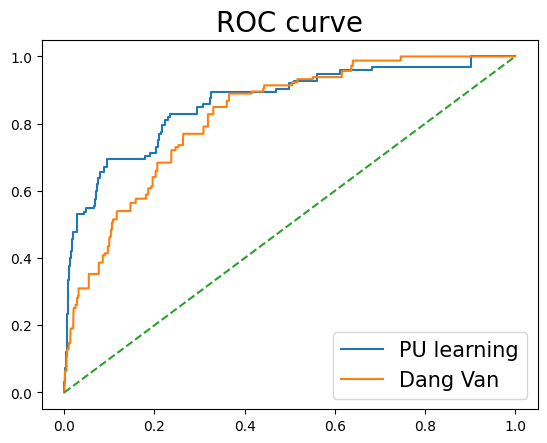

In [19]:
plt.plot(fpr, tpr, label='PU learning')
plt.plot(fpr2, tpr2, label='Dang Van')
plt.plot([0,1],[0,1], linestyle='dashed')
plt.legend(fontsize=15)
plt.title('ROC curve', fontsize=20)
plt.show()

In [20]:
a, b, c = precision_recall_curve(Z_test, model.predict_clogproba(X_test))
d, e, f = precision_recall_curve(Z_test, dataset.predict_DV_dim(testing=True))

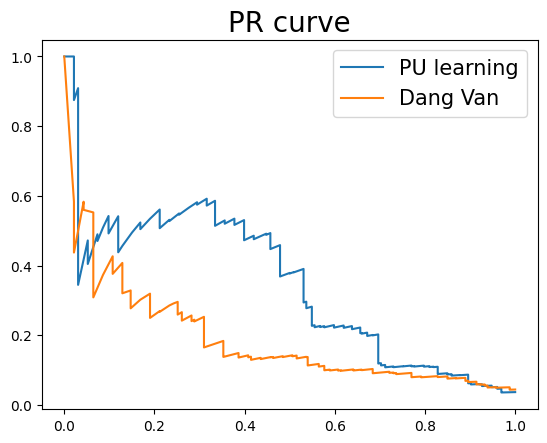

In [21]:
plt.plot(b, a, label='PU learning')
plt.plot(e, d, label='Dang Van')
plt.legend(fontsize=15)
plt.title('PR curve', fontsize=20)
plt.show()